# Lab 10 MNIST and Softmax

## Lab10-8-mnist_nn_selu(wip)
- SELU implementation from https://github.com/bioinf-jku/SNNs/blob/master/selu.py

In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
# -*- coding: utf-8 -*-
'''
Tensorflow Implementation of the Scaled ELU function and Dropout
'''
import numbers
from tensorflow.contrib import layers
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.layers import utils

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
tf.set_random_seed(777)  # reproducibility

In [3]:
def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x))

In [4]:
def dropout_selu(x, keep_prob, alpha= -1.7580993408473766, fixedPointMean=0.0, fixedPointVar=1.0,
                 noise_shape=None, seed=None, name=None, training=False):
    """Dropout to a value with rescaling."""

    def dropout_selu_impl(x, rate, alpha, noise_shape, seed, name):
        keep_prob = 1.0 - rate
        x = ops.convert_to_tensor(x, name="x")
        if isinstance(keep_prob, numbers.Real) and not 0 < keep_prob <= 1:
            raise ValueError("keep_prob must be a scalar tensor or a float in the "
                                             "range (0, 1], got %g" % keep_prob)
        keep_prob = ops.convert_to_tensor(keep_prob, dtype=x.dtype, name="keep_prob")
        keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

        alpha = ops.convert_to_tensor(alpha, dtype=x.dtype, name="alpha")
        keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

        if tensor_util.constant_value(keep_prob) == 1:
            return x

        noise_shape = noise_shape if noise_shape is not None else array_ops.shape(x)
        random_tensor = keep_prob
        random_tensor += random_ops.random_uniform(noise_shape, seed=seed, dtype=x.dtype)
        binary_tensor = math_ops.floor(random_tensor)
        ret = x * binary_tensor + alpha * (1-binary_tensor)

        a = tf.sqrt(fixedPointVar / (keep_prob *((1-keep_prob) * tf.pow(alpha-fixedPointMean,2) + fixedPointVar)))

        b = fixedPointMean - a * (keep_prob * fixedPointMean + (1 - keep_prob) * alpha)
        ret = a * ret + b
        ret.set_shape(x.get_shape())
        return ret

    with ops.name_scope(name, "dropout", [x]) as name:
        return utils.smart_cond(training,
                                lambda: dropout_selu_impl(x, keep_prob, alpha, noise_shape, seed, name),
                                lambda: array_ops.identity(x))

In [5]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
# parameters
learning_rate = 0.001
training_epochs = 50
batch_size = 100

In [7]:
# input place holders
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

In [8]:
# dropout (keep_prob) rate  0.7 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

In [9]:
# weights & bias for nn layers
# http://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
W1 = tf.get_variable("W1", shape=[784, 512],
                     initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([512]))
L1 = selu(tf.matmul(X, W1) + b1)
L1 = dropout_selu(L1, keep_prob=keep_prob)

In [10]:
W2 = tf.get_variable("W2", shape=[512, 512],
                     initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([512]))
L2 = selu(tf.matmul(L1, W2) + b2)
L2 = dropout_selu(L2, keep_prob=keep_prob)

In [11]:
W3 = tf.get_variable("W3", shape=[512, 512],
                     initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([512]))
L3 = selu(tf.matmul(L2, W3) + b3)
L3 = dropout_selu(L3, keep_prob=keep_prob)

In [12]:
W4 = tf.get_variable("W4", shape=[512, 512],
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([512]))
L4 = selu(tf.matmul(L3, W4) + b4)
L4 = dropout_selu(L4, keep_prob=keep_prob)

In [13]:
W5 = tf.get_variable("W5", shape=[512, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([10]))
hypothesis = tf.matmul(L4, W5) + b5

In [14]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [15]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

Epoch: 0001 cost = 0.525002178
Epoch: 0002 cost = 0.161724900
Epoch: 0003 cost = 0.125785579
Epoch: 0004 cost = 0.108473961
Epoch: 0005 cost = 0.094301452
Epoch: 0006 cost = 0.090414509
Epoch: 0007 cost = 0.080968445
Epoch: 0008 cost = 0.081822040
Epoch: 0009 cost = 0.078143769
Epoch: 0010 cost = 0.070925551
Epoch: 0011 cost = 0.061887159
Epoch: 0012 cost = 0.067059740
Epoch: 0013 cost = 0.056846072
Epoch: 0014 cost = 0.056757542
Epoch: 0015 cost = 0.051696500
Epoch: 0016 cost = 0.048612948
Epoch: 0017 cost = 0.043807761
Epoch: 0018 cost = 0.047413503
Epoch: 0019 cost = 0.054793650
Epoch: 0020 cost = 0.043326182
Epoch: 0021 cost = 0.041824071
Epoch: 0022 cost = 0.043296074
Epoch: 0023 cost = 0.044776860
Epoch: 0024 cost = 0.029144197
Epoch: 0025 cost = 0.035353001
Epoch: 0026 cost = 0.048023093
Epoch: 0027 cost = 0.028468076
Epoch: 0028 cost = 0.042459968
Epoch: 0029 cost = 0.058238270
Epoch: 0030 cost = 0.031389067
Epoch: 0031 cost = 0.022616670
Epoch: 0032 cost = 0.025290699
Epoch: 0

In [17]:
# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}))

Accuracy: 0.9831


In [18]:
# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(hypothesis, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 1}))

Label:  [1]
Prediction:  [1]


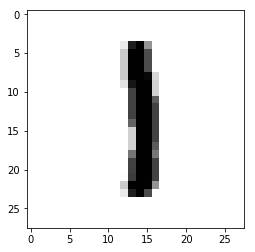

'\nEpoch: 0001 cost = 0.447322626\nEpoch: 0002 cost = 0.157285590\nEpoch: 0003 cost = 0.121884535\nEpoch: 0004 cost = 0.098128681\nEpoch: 0005 cost = 0.082901778\nEpoch: 0006 cost = 0.075337573\nEpoch: 0007 cost = 0.069752543\nEpoch: 0008 cost = 0.060884363\nEpoch: 0009 cost = 0.055276413\nEpoch: 0010 cost = 0.054631256\nEpoch: 0011 cost = 0.049675195\nEpoch: 0012 cost = 0.049125314\nEpoch: 0013 cost = 0.047231930\nEpoch: 0014 cost = 0.041290121\nEpoch: 0015 cost = 0.043621063\nLearning Finished!\nAccuracy: 0.9804\n'

In [19]:
plt.imshow(mnist.test.images[r:r + 1].
          reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

'''
Epoch: 0001 cost = 0.447322626
Epoch: 0002 cost = 0.157285590
Epoch: 0003 cost = 0.121884535
Epoch: 0004 cost = 0.098128681
Epoch: 0005 cost = 0.082901778
Epoch: 0006 cost = 0.075337573
Epoch: 0007 cost = 0.069752543
Epoch: 0008 cost = 0.060884363
Epoch: 0009 cost = 0.055276413
Epoch: 0010 cost = 0.054631256
Epoch: 0011 cost = 0.049675195
Epoch: 0012 cost = 0.049125314
Epoch: 0013 cost = 0.047231930
Epoch: 0014 cost = 0.041290121
Epoch: 0015 cost = 0.043621063
Learning Finished!
Accuracy: 0.9804
'''
